# SML project - SMS spam detection

### Olivier Pelgrin, François Mentec, Hugo Martin

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.neural_network import MLPClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn import tree

import matplotlib.pyplot as plt

import re # regex

In [2]:
#Import spam data and shaping it
smsList = pd.read_table("SMSSpamCollection.txt", header=None, names=['label', 'message'])

smsList["label"] = smsList["label"].map({"ham":0,"spam":1})

X = smsList.message
y = smsList.label

## Naive bayes

We will start by using a Naive Bayes as a baseline classifier.  
Naive Bayes are known to have good results for text classification.

In [3]:
#Splitting dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
vect = CountVectorizer()

In [5]:
X_train_vect = vect.fit_transform(X_train)

In [6]:
X_test_vect = vect.transform(X_test)

In [7]:
nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

y_prediction_class = nb.predict(X_test_vect)

metrics.accuracy_score(y_test, y_prediction_class)

0.98851399856424982

### With 10-fold cross validation :

In [12]:
#A function that evaluate a machine learning model with 10-fold cross validation
def cross_val(model):
    kf = KFold(n_splits=10)
    
    res = []
    
    for train_i, test_i in kf.split(X, y):
        cv = CountVectorizer()

        train_set = cv.fit_transform([X[i] for i in train_i])
        train_class = [y[i] for i in train_i]

        test_set = cv.transform([X[i] for i in test_i])
        test_class = [y[i] for i in test_i]

        model.fit(train_set,train_class)
        pred = model.predict(test_set)
        
        r = metrics.accuracy_score(test_class, pred)
        print(r)
        res.append(r)
        
    return np.mean(res)

In [9]:
nb = MultinomialNB()

nb_score = cross_val(nb)

print("Naive Bayes : " + str(nb_score*100) + "% accuracy")

0.989247311828
0.978494623656
0.980251346499
0.991023339318
0.982046678636
0.992818671454
0.983842010772
0.989228007181
0.980251346499
0.992818671454
Naive Bayes : 98.600220073% accuracy


In [85]:
import nltk.stem

stemmer = nltk.stem.SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

#A function that compute diverse metrics like confusion matrix, accuracy score and ROC Curve.
def compute_metrics(model, vect_type='count'):
    vect = CountVectorizer()
    
    if(vect_type=='stemmed'):
        print("Use of stemmed count vectorizer")
        vect = StemmedCountVectorizer(min_df=3, analyzer="word", stop_words='english')
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    X_train_vect = vect.fit_transform(X_train)
    X_test_vect = vect.transform(X_test)
    
    model.fit(X_train_vect, y_train)

    y_prediction_class = model.predict(X_test_vect)

    preds = model.predict_proba(X_test_vect)[:,1]
    
    false_positive = X_test[(y_prediction_class==1) & (y_test==0)]
    false_negative = X_test[(y_prediction_class < y_test)]

    cm = metrics.confusion_matrix(y_test, y_prediction_class)
    print(cm)

    fpr, tpr, _ = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    lw = 3
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    print("False positive : ")
    print(false_positive)
    print("False negative : ")
    print(false_negative)
    
    acc = metrics.accuracy_score(y_test, y_prediction_class)
    print("Accuracy : " + str(acc))

[[1203    4]
 [  12  174]]


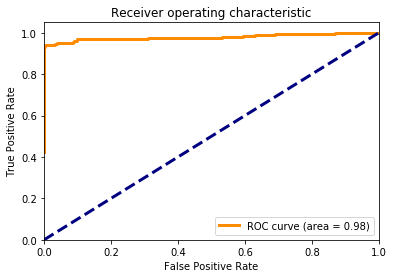

False positive : 
1988                     No calls..messages..missed calls
45                       No calls..messages..missed calls
1260    We have sent JD for Customer Service cum Accou...
2173     Yavnt tried yet and never played original either
Name: message, dtype: object
False negative : 
3864    Oh my god! I've found your number again! I'm s...
2575    Your next amazing xxx PICSFREE1 video will be ...
2402    Babe: U want me dont u baby! Im nasty and have...
2663    Hello darling how are you today? I would love ...
751     Do you realize that in about 40 years, we'll h...
856     Talk sexy!! Make new friends or fall in love i...
3360    Sorry I missed your call let's talk when you h...
3425    Am new 2 club & dont fink we met yet Will B gr...
731     Email AlertFrom: Jeri StewartSize: 2KBSubject:...
1893    CALL 09090900040 & LISTEN TO EXTREME DIRTY LIV...
68      Did you hear about the new "Divorce Barbie"? I...
3132    LookAtMe!: Thanks for your purchase of a video...
Name: m

In [52]:
nb = MultinomialNB()
compute_metrics(nb)

Naive Bayes models are known to have good results in text classification, so it is not surprising to have such a good score and ROC Curve, with an excellent 0.98 AUC score.  
The confusion matrix show us that there is few false positive and false negative.

## Backpropagation neural network
We're implementing the technique presented in this article :
[RUAN, Guangchen et TAN, Ying. A three-layer back-propagation neural network for spam detection using artificial immune concentration. Soft computing, 2010, vol. 14, no 2, p. 139-150.](https://link.springer.com/content/pdf/10.1007%2Fs00500-009-0440-2.pdf)

In [5]:
ENGLISH_STOP_WORDS = frozenset([
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
    "yourselves"])

In [6]:
regex = re.compile('\w+')
words = {}
N = 0 # number of non-spam
S = 0 # number of spam

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

"""count words support in spam and non-spam sms
words['toto'][0] = number of non-spam sms containing the word 'toto'
words['toto'][1] = number of spam sms containing the word 'toto'
words['toto'][0] + words['toto'][1] = number of sms containing the word 'toto'
"""
for i in X_train.index:
    X_train[i] = X_train[i].lower()
    message = X_train[i]
    spam = y_train[i]
    # print(str(i) + " (" + str(spam) + ") - " + message)
    if spam == 0:
        N += 1
    else:
        S += 1
    messageWords = list(set(regex.findall(message))) # doesn't take duplicate
    for word in messageWords:
        if word in words:
            words[word][spam] += 1
        else:
            words[word] = [(spam + 1) % 2, spam]

# we only keep words that appears in less than 95% of sms
genes = []
for i in words:
    if words[i][0] + words[i][1] >= 0.95 * len(X_train):
        del words[i]
    else:
        words[i].append(words[i][0] / N) # frequency appearing in non-spam
        words[i].append(words[i][1] / S) # frequency appearing in spam
        words[i].append(words[i][2] - words[i][3]) # calculate "proclivity" Cf "4.2 Generation of gene libraries"
        genes.append(i)
    
genes.sort(key = lambda a: -words[a][4])

selfGenes = genes[:round(len(genes) * 0.25)]
nonSelfGenes = genes[-round(len(genes) * 0.25):]

def getFeatures(message):
    self = 0
    nonSelf = 0
    messageWords = list(set(regex.findall(message)))
    for word in messageWords:
        if word in selfGenes:
            self += 1
        elif word in nonSelfGenes:
            nonSelf += 1
    #return [self / max(1, len(messageWords)), nonSelf / max(1, len(messageWords))]
    return [self, nonSelf] # got better results than the concentration proposed in the paper

In [7]:
X_train_features = []

for message in X_train:
    X_train_features.append(getFeatures(message))
    
X_test_features = []

for message in X_test:
    X_test_features.append(getFeatures(message))

In [8]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(3), random_state=1, activation='logistic')
clf.fit(X_train_features, y_train)

test = clf.predict(X_test_features)
correct = 0

for i in range(len(test)):
    if test[i] == y_test[X_test.index[i]]:
        correct += 1
        
print(correct / len(test))

0.9820627802690582


In [9]:
clf.predict([getFeatures('hey honey can u buy milk on your way home?')])

array([0])

In [10]:
clf.predict([getFeatures('wanna win a new car? call this phone number asap 01245145624!!!')])

array([1])

The MultilayerPercetron have good results, on par with the Naive Bayes. But it isn't better despite being a much more complex classifier.

## Support Vector Machine

In this section we will test different SVM and analyse their results.

### SVM with linear kernel

In [13]:
lsvm = LinearSVC()

#We use a 10 fold cross-validation to evaluate the SVM performance
   
score_linear = cross_val(lsvm)

print("SVM with linear kernel : " + str(score_linear*100) + "% accuracy")

0.991039426523
0.976702508961
0.983842010772
0.991023339318
0.978456014363
0.985637342908
0.985637342908
0.980251346499
0.989228007181
0.991023339318
SVM with linear kernel : 98.5284067875% accuracy


[[1206    1]
 [  20  166]]


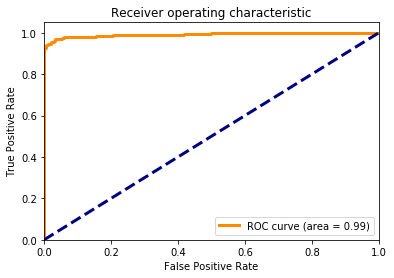

False positive : 
1630    Sounds like you have many talents! would you l...
Name: message, dtype: object
False negative : 
3864    Oh my god! I've found your number again! I'm s...
2402    Babe: U want me dont u baby! Im nasty and have...
2663    Hello darling how are you today? I would love ...
751     Do you realize that in about 40 years, we'll h...
4410    For your chance to WIN a FREE Bluetooth Headse...
763     Urgent Ur £500 guaranteed award is still uncla...
4047        Win a £1000 cash prize or a prize worth £5000
3885    A link to your picture has been sent. You can ...
3360    Sorry I missed your call let's talk when you h...
2770    Burger King - Wanna play footy at a top stadiu...
5120         PRIVATE! Your 2003 Account Statement for 078
4295    Kit Strip - you have been billed 150p. Netcoll...
731     Email AlertFrom: Jeri StewartSize: 2KBSubject:...
1893    CALL 09090900040 & LISTEN TO EXTREME DIRTY LIV...
415     100 dating service cal;l 09064012103 box334sk38ch
1777   

In [53]:
lsvm = SVC(kernel='linear', probability=True)
compute_metrics(lsvm)

The ROC curve of the SVM with linear kernel is very close to a perfect classifier with AUC of 0.99. This mean that SVM (with linear kernel) is a pretty good machine learning algorithm for SPAM detection.  
Also, SVM linear make few mistake, with only 1 false positive and 20 false negative.   
Compared to the Naive Bayes, there is less false positive, but more false negative.  
So even if the ROC curve is better than the Naive Bayes's ROC curve, it may be a worst classifier because we probably don't want many false negative.

Separate spam and non spam being a simple binary classification problem, a simple linear function seems to be enough.   Overall, with the Naive Bayes having very good results, we can guess that there is no need for complex systems to make good predictions.

Since SVM with Linear kernel is one of the best classifier (except Naive Bayes), we will test if Grid Search can give us even better results : 


In [64]:
from sklearn.model_selection import GridSearchCV

vect = CountVectorizer()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

lsvm = SVC(kernel='linear', probability=True)

param = {'C':[1, 10, 100, 1000, 10000]}
gs_svm = GridSearchCV(lsvm, param, n_jobs=-1)

gs_clf = gs_svm.fit(X_train_vect, y_train)
gs_clf.predict(X_test_vect)

print(gs_clf.best_score_)

0.984206748026


Grid Search dosn't improve the classifier accuracy, meaning that the SVM is already as efficient as it can probably be.

Next we will try if a better text pre-processing help with the result

Use of stemmed count vectorizer
[[1204    3]
 [  18  168]]


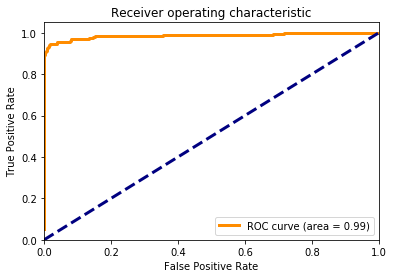

False positive : 
439     Hi hope u get this txt~journey hasnt been gd,n...
3197    I av a new number,  . Wil u only use this one,ta.
841     I luv u soo much u dont understand how specia...
Name: message, dtype: object
False negative : 
3864    Oh my god! I've found your number again! I'm s...
2402    Babe: U want me dont u baby! Im nasty and have...
2663    Hello darling how are you today? I would love ...
751     Do you realize that in about 40 years, we'll h...
4410    For your chance to WIN a FREE Bluetooth Headse...
227     Will u meet ur dream partner soon? Is ur caree...
1073    Dear U've been invited to XCHAT. This is our f...
3360    Sorry I missed your call let's talk when you h...
2770    Burger King - Wanna play footy at a top stadiu...
5120         PRIVATE! Your 2003 Account Statement for 078
4295    Kit Strip - you have been billed 150p. Netcoll...
731     Email AlertFrom: Jeri StewartSize: 2KBSubject:...
1893    CALL 09090900040 & LISTEN TO EXTREME DIRTY LIV...
1777   

In [73]:
lsvm = SVC(kernel='linear', probability=True)

compute_metrics(lsvm, 'stemmed')

The use of the stemmed vectorizer that stop words into account, the result doesn't get much better.  
This lead us to believe that languages features aren't very important when it come to detect spams.

Taking the example from the "MLforTextClassification" provided notebook, it will be interesting to see what are the most important tokens for spam detection. We will have to use a Naive Bayes for that, SVM doesn't provide the metrics needed to perform that.

In [74]:
nb = MultinomialNB()
nb.fit(X_train_vect, y_train)

X_train_tokens = vect.get_feature_names()
ham_token_count = nb.feature_count_[0, :]
spam_token_count = nb.feature_count_[1, :]

tokens = pd.DataFrame({"token":X_train_tokens, "ham":ham_token_count, "spam":spam_token_count}).set_index("token")
tokens['ham'] = tokens['ham'] + 1
tokens['spam'] = tokens['spam'] + 1
tokens['spam_ratio'] = tokens['spam'] / tokens['ham']

tokens.sort_values('spam_ratio', ascending=False)

,ham,spam,spam_ratio
token,,,
claim,1.0,81.0,81.000000
tone,1.0,71.0,71.000000
prize,1.0,61.0,61.000000
150p,1.0,54.0,54.000000
18,1.0,40.0,40.000000
guarante,1.0,39.0,39.000000
cs,1.0,35.0,35.000000
rington,1.0,34.0,34.000000
1000,1.0,34.0,34.000000


As we can see, even without stop words taken into acount, they don't seems very important for the classification.
So when we use a vectorizer that take stops words into account, it doesn't help the classifier.

### SVM with polynomial kernel

In [15]:
psvm = SVC(kernel='poly')

score_poly = cross_val(psvm)

print("SVM with polynomial kernel : " + str(score_poly*100) + "% accuracy")

0.856630824373
0.84229390681
0.876122082585
0.870736086176
0.870736086176
0.883303411131
0.868940754039
0.850987432675
0.868940754039
0.870736086176
SVM with polynomial kernel : 86.5942742418% accuracy


[[1207    0]
 [ 186    0]]


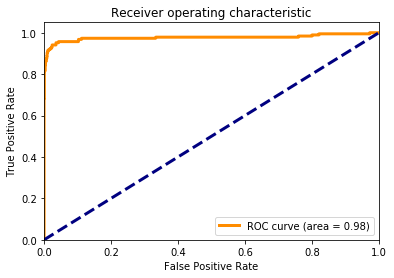

False positive : 
Series([], Name: message, dtype: object)
False negative : 
401     FREE RINGTONE text FIRST to 87131 for a poly o...
5567    This is the 2nd time we have tried 2 contact u...
881     Reminder: You have not downloaded the content ...
1961    Guess what! Somebody you know secretly fancies...
2664    8007 FREE for 1st week! No1 Nokia tone 4 ur mo...
1598    URGENT! Your Mobile number has been awarded wi...
3299    This message is free. Welcome to the new & imp...
4500    SMS SERVICES. for your inclusive text credits,...
296     T-Mobile customer you may now claim your FREE ...
3298    Todays Voda numbers ending 5226 are selected t...
3864    Oh my god! I've found your number again! I'm s...
8       WINNER!! As a valued network customer you have...
2575    Your next amazing xxx PICSFREE1 video will be ...
319     December only! Had your mobile 11mths+? You ar...
3548    Rock yr chik. Get 100's of filthy films &XXX p...
5178    SMS AUCTION - A BRAND NEW Nokia 7250 is up 4 

In [36]:
svm = SVC(kernel='poly', probability=True)
compute_metrics(svm)

The SVM with polynomial kernel also have a good ROC curve. But we can see that the AUC score is lower than SVM with linear kernel. We know that SVM Polynomial have a 86% accuracy, which is much lower than the others classifier tested.  
The confusion matrix show us that in fact SVM with poly kernel allways predict the SMS to not be a spam.  
Since most SMS aren't spam, it has a good score. Still, it isn't a very interesting model.

### SVM with rbf kernel

In [18]:
rsvm = SVC(kernel='rbf')

score_rbf = cross_val(rsvm)

print("SVM with rbf kernel : " + str(score_rbf*100) + "% accuracy")

0.856630824373
0.84229390681
0.876122082585
0.870736086176
0.870736086176
0.883303411131
0.868940754039
0.850987432675
0.868940754039
0.870736086176
SVM with rbf kernel : 86.5942742418% accuracy


### SVM with sigmoid kernel

In [19]:
ssvm = SVC(kernel='sigmoid')

score_sigmoid = cross_val(ssvm)

print("SVM with sigmoid kernel : " + str(score_sigmoid*100) + "% accuracy")

0.856630824373
0.84229390681
0.876122082585
0.870736086176
0.870736086176
0.883303411131
0.868940754039
0.850987432675
0.868940754039
0.870736086176
SVM with sigmoid kernel : 86.5942742418% accuracy


All SVM with non-linear kernel all obtain the same 86.59%, which is a bit odd as we use different kernels. It probably show that the spam detection problem is simple enough that learning anything more complicated than a linear function doesn't work well.

Analysis of the confusion matrix show that all of these SVMs allways predict SMS to be a "legit" SMS, which make them not very interesting.

## Decision Tree

In [20]:
t = tree.DecisionTreeClassifier()

score_tree = cross_val(t)

print("Decision Tree score : " + str(score_tree*100) + "% accuracy")

0.967741935484
0.980286738351
0.967684021544
0.971274685817
0.96947935368
0.97486535009
0.962298025135
0.964093357271
0.956912028725
0.97486535009
Decision Tree score : 96.8950084619% accuracy


The decision tree work pretty well, doing 96% accuracy on average.  
This is a really good accuracy considering that decision tree can only separate example with simple vertical or horizontal hyperplans. But we already saw that learning complex function doesn't help much for spam detection.

[[1192   15]
 [  26  160]]


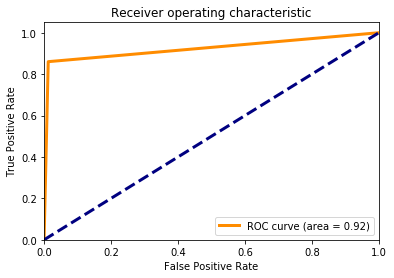

False positive : 
3142                       Customer place i will call you
2422    Err... Cud do. I'm going to  at 8pm. I haven't...
2225    I prefer my free days... Tues, wed, fri oso ca...
1335    Oh ! A half hour is much longer in Syria than ...
132               Dear, will call Tmorrow.pls accomodate.
2905    HI DARLIN I HOPE YOU HAD A NICE NIGHT I WISH I...
3728        Aldrine, rakhesh ex RTM here.pls call.urgent.
199     Hi its Kate how is your evening? I hope i can ...
486         If we win its really no 1 side for long time.
3832    Let's pool our money together and buy a bunch ...
387                       Customer place i will call you.
4951    Hi its me you are probably having too much fun...
5063    Havent stuck at orchard in my dad's car. Going...
566     Ill call u 2mrw at ninish, with my address tha...
4006    , ow u dey.i paid 60,400thousad.i told  u woul...
Name: message, dtype: object
False negative : 
881     Reminder: You have not downloaded the content ...
1961   

In [37]:
t = tree.DecisionTreeClassifier()
compute_metrics(t)

With the confusion matrix, we can see that decistion tree is pretty accurate. But it is worst than all the others classifier, except SVM with non-linear kernels.

### Experiment with POS tagging

In [86]:
from nltk.tokenize import word_tokenize

def tag_text(s):
    r = ""
    txt = word_tokenize(s)
    for e in nltk.pos_tag(txt):
        r += e[1] + " "
    return r

smsList = pd.read_table("SMSSpamCollection.txt", header=None, names=['label', 'message'])

smsList['message'] = smsList['message'].apply(tag_text)

smsList["label"] = smsList["label"].map({"ham":0,"spam":1})

X = smsList.message
y = smsList.label

[[1149   58]
 [  47  139]]


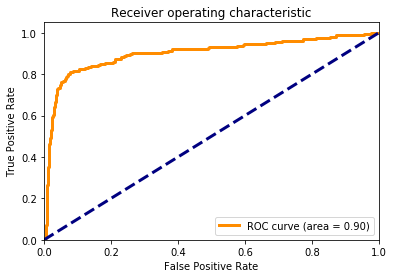

False positive : 
4315    VBZ JJ NNS CD NNS NN JJ . NNP JJ VBP RB VBN NN...
3407    NNP NNP NNP : NNP NNP CD NNP NNP NNP NNP NNP ....
3547    RB NNP NNP NNP NNP NNP VBZ NNP PRP VBP . . . N...
1055    NNP NNP CD NNP CD NNP NNP NNP NNP . NNP NNP NN...
1033                             NNP NNP NNP NNP NNP NNP 
3307    NNP NNP PRP VBP $ CD NNP NNP CD CD NNPS NNP NN...
4536                         NNP NNP NNP NNP NNP NNP NNP 
5125    IN PRP$ NN NN : NNP CD CC NN : NNP FW NN NN : ...
1879                     PRP VBP NNP NNP NNP NNP NNP NNP 
3199                 CD NN : NNP CD NN : NNP NN JJ VBG . 
1779    CD NNS IN NNP NNP CD PRP CD NNP NN CD NNP NN C...
5155    PRP$ JJ NNP NNP NNP NNP . PRP VBP IN NNP NNP N...
893     NNP . NNP . NNP . NNP . NNP . NNP . NNP . NN PRP 
1612                                                  CD 
2746                          NNP NNP VBG CD NN POS NN . 
1562         NNP NN : NN NN NNS IN DT NN JJ VBP CD NNS . 
2905    NNP NNP PRP VBP PRP VBD NNP NNP NNP PRP NNP PR

In [88]:
nb = MultinomialNB()

compute_metrics(nb)

Attempt to generalize message content by using tagged text instead of the real text lower the classifier performance. This means that the loss of information due to the use of tags instead of the actuel text is significant enough to impact the classifier performance.  
Still, we have a 92% accuracy with 0.9 AUC, which is not that bad.

## Conclusion

From all the classifier tested, allmost all of them are around 98% of succesfull classification for this problem of spam detection.  
The best classifier seems to be the Naive Bayes which is difficult to beat, even with more complex system like Perceptron and Support Vector Machines.

The success of simple machine learning algorithms like Naive Bayes (even the Decision Tree provide a pretty good classification), show us that the spam detection seems to be an "easy" machine learning problem, because using complex machine learning methods doesn't improve the already good results we have with simpler algorithms.
